# Import libraries and modules

In [94]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import warnings
from contextlib import contextmanager
from copy import copy
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 5
n_samples_train = 2000
n_samples_test = 500

poly_order = 2
threshold = 0
dt = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [95]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

# Load data

In [96]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

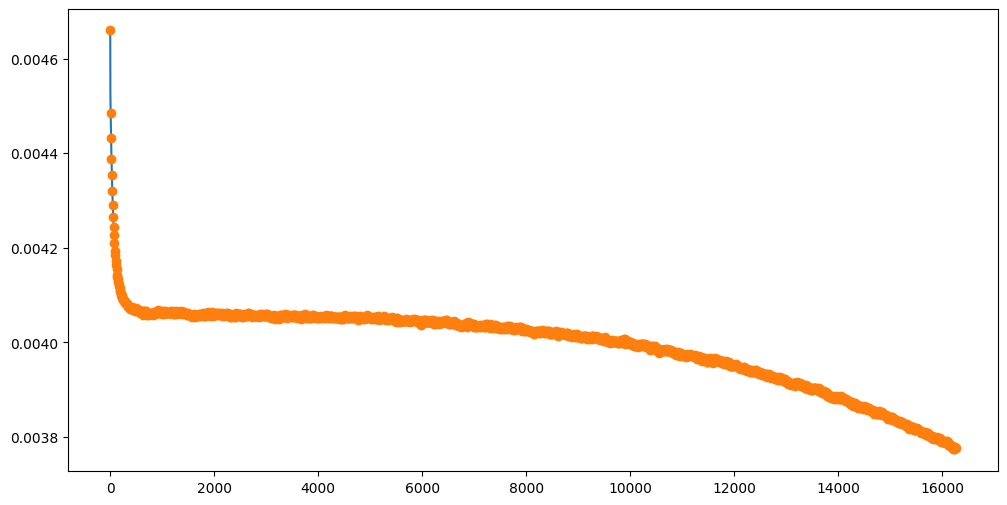

In [97]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Prepare the model (add constraints)

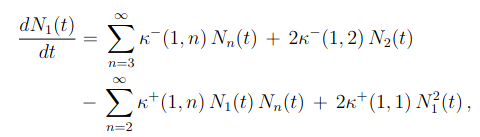

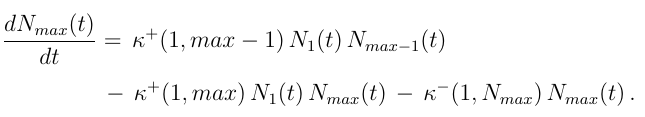

In [98]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
features_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", features_names)

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


## Tests

In [99]:
# Repeat with inequality constraints, need CVXPY installed
try:
    import cvxpy  # noqa: F401

    run_cvxpy = True

    # eps = np.sqrt(np.finfo(float).eps)
    eps_value = 1e-6
    large_value = 1e6

    print('eps:', eps_value)
    print('large_value:', large_value)

except ImportError:
    run_cvxpy = False
    print("No CVXPY package is installed")

eps: 1e-06
large_value: 1000000.0


## Set up and 1st eq

In [100]:
#### Set constraints
# Number of clusters/equations
n_targets = N_clusters_train.shape[1]

print(f"Features ({n_features}):", features_names)

# Find the index of the constant term '1'
constant_term_idx = features_names.index('1')

## Coefficients of quadratic terms are zero except for x0^2
# Find indices of quadratic terms excluding 'x0^2'
# # quadratic_idx_first = [i for i, feature_name in enumerate(features_names) if ('^2' in feature_name or feature_name.count('x') == 2) and 'x0' not in feature_name]
quadratic_idx_first = [i for i, feature_name in enumerate(features_names) \
                    if ('^2' in feature_name and 'x0' not in feature_name) \
                        or (feature_name.count('x') == 2 and 'x0' not in feature_name)]
n_quadratic_first = len(quadratic_idx_first)

# Initialize constraint_rhs and constraint_lhs for quadratic terms
constraint_rhs = np.zeros(n_quadratic_first)
constraint_lhs = np.zeros((n_quadratic_first, n_targets * n_features))

# Set coefficients of each quadratic term (excluding 'x0^2') to zero
for i, idx in enumerate(quadratic_idx_first):
    constraint_lhs[i, idx] = 1

## Coefficient of x0 is zero
constraint_rhs = np.append(constraint_rhs, 0)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
x0_idx = features_names.index('x0')
constraint_lhs[-1, x0_idx] = 1

## Constant term is zero
constraint_rhs = np.append(constraint_rhs, 0)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, constant_term_idx] = 1

last_row = n_quadratic_first + 2

## Inequality constraints
# Coefficient of x0^2 is positive
# x0^2 <= large_value
constraint_rhs = np.append(constraint_rhs, large_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
x0sqs_idx = features_names.index('x0^2')
constraint_lhs[-1, x0sqs_idx] = 1

# x0^2 >= eps
constraint_rhs = np.append(constraint_rhs, eps_value)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, x0sqs_idx] = -1

# Adjust for the number of constraints
last_row = last_row + 2

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


## Eq 2 to N-1

In [101]:
print(f"Features ({n_features}):", features_names)

### Add constraints for the middle cluster sizes (Eq 2 to N-1)
## All linear terms to be zero except for xN and xN+1
for eq in range(1, n_targets - 1):
    # Find the indices of linear terms excluding 'xN' and 'xN+1'
    linear_indices = [i for i, feature_name in enumerate(features_names) if 
                      (feature_name.count('x') == 1 and f'x{eq}' != feature_name and f'x{eq + 1}' != feature_name) 
                      and '^' not in feature_name]

    n_linear = len(linear_indices)

    # Add more columns to constraint_rhs and rows to constraint_lhs
    constraint_rhs = np.append(constraint_rhs, np.zeros(n_linear))
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_linear, n_targets * n_features))))

    # Set the coefficient of each linear term (excluding 'xN' and 'xN+1') to zero
    for i, idx in enumerate(linear_indices):
        constraint_lhs[i + last_row, eq * n_features + idx] = 1

    last_row += n_linear

    ## All quadratic terms to be zero except for x0 xN and x0 xN-1 (including x0^2)
    quadratic_idx_mix = [i for i, feature_name in enumerate(features_names) if 
                         (feature_name.count('x') == 2 and f'x0 x{eq}' != feature_name and f'x0 x{eq - 1}' != feature_name) 
                         or ('^2' in feature_name and 'x0' not in feature_name) 
                         or ('x0^2' in feature_name and eq != 1)]
    n_quadratic_mix = len(quadratic_idx_mix)

    # Add more columns to constraint_rhs and rows to constraint_lhs
    constraint_rhs = np.append(constraint_rhs, np.zeros(n_quadratic_mix))
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_quadratic_mix, n_targets * n_features))))

    # Set the coefficient of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to zero
    for i, idx in enumerate(quadratic_idx_mix):
        constraint_lhs[i + last_row, eq * n_features + idx] = 1

    ## Constant term is zero
    constraint_rhs = np.append(constraint_rhs, 0)
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
    constraint_lhs[-1, eq * n_features + constant_term_idx] = 1

    last_row += n_quadratic_mix + 1

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


## Last equation

In [102]:
print(f"Features ({n_features}):", features_names)

### Add constraints for the last cluster size (Eq N)
## All linear terms to be zero except for xN
linear_indices = [i for i, feature_name in enumerate(features_names) if feature_name.count('x') == 1 
                  and '^' not in feature_name 
                  and f'x{n_targets - 1}' not in feature_name]
n_linear = len(linear_indices)

# Add more columns to constraint_rhs and rows to constraint_lhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_linear))
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_linear, n_targets * n_features))))

# Set the coefficient of each linear term (excluding 'xN') to zero
for i, idx in enumerate(linear_indices):
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

last_row += n_linear

## All quadratic terms to be zero except for x0 xN and x0 xN-1
quadratic_idx_last = [i for i, feature_name in enumerate(features_names) if 
                      (feature_name.count('x') == 2 and f'x0 x{n_targets - 1}' not in feature_name 
                       and f'x0 x{n_targets - 2}' not in feature_name) 
                      or '^2' in feature_name]
n_quadratic_last = len(quadratic_idx_last)
  
# Add more columns to constraint_rhs and rows to constraint_lhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_quadratic_last))
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_quadratic_last, n_targets * n_features))))

# Set the coefficient of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to zero
for i, idx in enumerate(quadratic_idx_last):
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

## Constant term is zero
constraint_rhs = np.append(constraint_rhs, 0)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
constraint_lhs[-1, (n_targets - 1) * n_features + constant_term_idx] = 1


Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


# Build and fit the model

In [123]:
# # Repeat with inequality constraints
# # constraint_rhs = np.array([2, 2, large_value, eps_value])
# constraint_rhs = np.array([2, 2, 0.1, large_value])

# # One row per constraint, one column per coefficient
# constraint_lhs = np.zeros((constraint_rhs.shape[0], n_targets * n_features))

# # 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
# constraint_lhs[0, 1] = 2
# constraint_lhs[0, 2] = 5

# # -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
# constraint_lhs[1, 1] = -1
# constraint_lhs[1, 2] = -1

# # 1 * (x0 coefficient) <= 28
# constraint_lhs[2, 1 + n_features] = 1

# # -28 <= 1 * (x0 coefficient)
# constraint_lhs[3, 1 + n_features] = 1

In [124]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})

differentiation_method = smoothed_fd

# optimizer = ps.STLSQ(threshold=threshold)
# Define the optimizer with the specified constraints

# optimizer = ps.ConstrainedSR3(
#     verbose=True,
#     # thresholder="l0",
#     # threshold=0.1,
#     # trimming_fraction=0.1,
#     # max_iter=5000,
#     constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs
# )

optimizer = ps.ConstrainedSR3(
    verbose=True,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,  # Ensure this is True for inequality constraints
    thresholder="l1",
    tol=1e-7,
    threshold=1e-10,
    max_iter=10000,
)

feature_library = ps.PolynomialLibrary(degree=poly_order)

with ignore_specific_warnings():
    # Fit the model
    model = ps.SINDy( 
        # discrete_time=True,
        differentiation_method=differentiation_method,
        optimizer=optimizer,
        # optimizer=[optimizer_first, optimizer_last],  # Pass a list of optimizers
        feature_library=feature_library,
    )
    model.fit(N_clusters_train, t=dt)

# Print the model
model.print()

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 2.9003e-09 ... 2.2820e+11 ... 1.3063e-14 ... 2.2820e+11
(x0)' = -0.059 x0 + 0.424 x1 + 0.625 x2 + -0.268 x3 + -0.172 x4
(x1)' = 0.030 x0 + -0.332 x1 + 0.304 x2 + 0.221 x3 + 0.092 x4
(x2)' = 0.005 x0 + -0.046 x1 + 0.002 x2
(x3)' = 0.001 x0 + -0.007 x1
(x4)' = -0.001 x1


In [125]:
print(f"Features ({n_features}):", features_names)

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


In [126]:
optimizer.coef_

array([[ 6.75049655e-05, -5.89684744e-02,  4.23587389e-01,
         6.25176851e-01, -2.68038579e-01, -1.72261887e-01,
         3.64247093e-12, -9.97590833e-12,  3.63060025e-12,
         7.31932018e-12,  3.61245371e-12,  8.54258537e-13,
         7.42955675e-13,  6.95505199e-13,  3.18298621e-13,
         2.27519101e-13,  1.37685566e-13,  5.79993404e-14,
         5.18496197e-14,  1.91307209e-14,  6.62199599e-15],
       [-3.12303575e-05,  2.97919541e-02, -3.32492066e-01,
         3.04342920e-01,  2.20666265e-01,  9.16396371e-02,
        -1.81834064e-11,  2.21976513e-11, -2.53879979e-11,
        -1.54753379e-11, -8.09937662e-12, -2.28631380e-12,
        -3.10929171e-12, -1.47564960e-12, -7.07149315e-13,
        -9.80459355e-13, -3.46300662e-13, -1.44474023e-13,
        -1.05585923e-13, -4.00942631e-14, -1.41353738e-14],
       [-5.94908774e-06,  5.22030822e-03, -4.62837823e-02,
         2.46105802e-03, -1.43412843e-11, -8.90547622e-12,
        -2.90760660e-13,  4.64122252e-13, -7.32837925e

In [127]:
auaua = akakka

NameError: name 'akakka' is not defined

In [ ]:
# N_clusters_train
# Find min value gretaer than 0
min_val = np.min(N_clusters_train[N_clusters_train > 0])
min_val

1.4997180530060347e-08

In [ ]:
# model.print_simpy()

In [ ]:
# # Print the model
# # model.print()

# save_folder = 'ck_experiments'
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
    
# model.save(save_folder, precision=4)

# Simulate and plot results

In [ ]:
N_clusters.shape, N_clusters[0].shape

((16257, 5), (5,))

In [ ]:
# # integrator_keywords['method'] = 'RK23'
# # integrator_keywords['rtol'] = 1e-4
# # integrator_keywords['atol'] = 1e-6
# integrator_keywords['method'] = 'BDF'
# integrator_keywords['rtol'] = 1e-3
# integrator_keywords['atol'] = 1e-10
# n_samples_test = 1000
# n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], integrator_kws=integrator_keywords)

integrator_keywords['method'] = 'Euler'   # 'RK2'   #'RK4' 
integrator_keywords['h_factor'] = 1000

n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                              integrator='fixed_step', integrator_kws=integrator_keywords)

fixed_step {'method': 'Euler', 'rtol': 1.0, 'atol': 1.0, 'max_step': 0.1, 'h_factor': 1000}
t: 32.0

t: 4998.0sol: [[4.65983645e-03 1.57597872e-04 7.29612833e-06 5.12403668e-07
  1.49971805e-08]
 [4.65983508e-03 1.57598392e-04 7.29609618e-06 5.12403010e-07
  1.49970637e-08]
 [4.65983370e-03 1.57598912e-04 7.29606403e-06 5.12402351e-07
  1.49969469e-08]
 ...
 [4.65302873e-03 1.60175321e-04 7.13392637e-06 5.09153904e-07
  1.44157142e-08]
 [4.65302738e-03 1.60175832e-04 7.13389360e-06 5.09153261e-07
  1.44155983e-08]
 [4.65302603e-03 1.60176344e-04 7.13386083e-06 5.09152619e-07
  1.44154823e-08]]
t: [0.000e+00 1.000e+00 2.000e+00 ... 4.997e+03 4.998e+03 4.999e+03]


In [ ]:
n_sim.shape, t_sim.shape

((5000, 5), (5000,))

/tmp/ipykernel_2893644/386159276.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)
/tmp/ipykernel_2893644/386159276.py:12: RuntimeWarning: divide by zero encountered in log
  t_sim_log = np.log(t_sim)


Cluster size 10 is larger than the system size 5
Cluster size 50 is larger than the system size 5
Cluster size 100 is larger than the system size 5


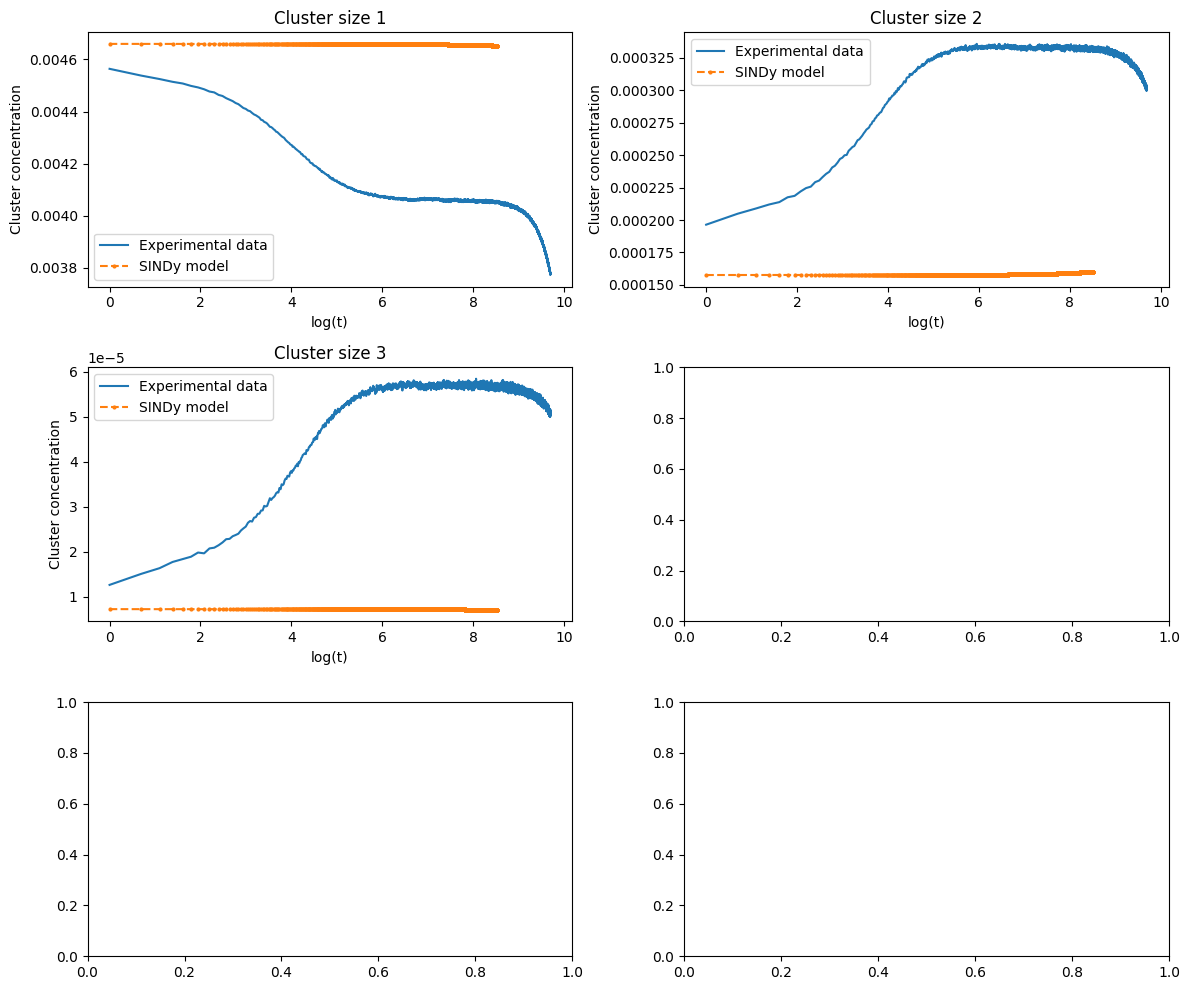

In [ ]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)
t_sim_log = np.log(t_sim)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model', marker='o', linestyle='dashed', markersize=2)
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()